# Look at Line2line channel gradients down centre of channel 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [2]:
# points_x_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_x.npy')
# points_y_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_points_y.npy')
# ice_thickn_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_all_interp_ice_thickn.npy')

In [3]:
points_x_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
points_y_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
ice_thickn_chan = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')
ice_base = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_icebase.npy')

In [9]:
it = ice_thickn_chan[10,:]
ib = ice_base[10,:]
x = points_x_chan[10,:]
y = points_y_chan[10,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it,'ice_base':ib})

points = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf = gpd.GeoDataFrame(mid,geometry=points,crs="EPSG:3031")

In [10]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()

In [11]:
add_distance_to_gdf(gdf)

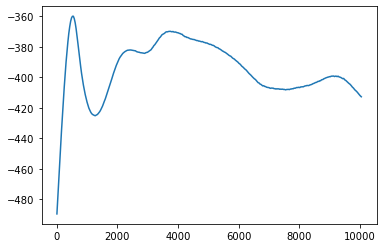

In [19]:
plt.plot(gdf.distan_cum,gdf.ice_base)

In [22]:
mins = gdf[np.abs(gdf.ice_base.diff()) < 0.02].copy()
mins

,x,y,ice_thickn,ice_base,geometry,dx,distan_cum,ditdx
18,-381075.673843,-725130.900896,426.608538,-360.061358,POINT (-381075.674 -725130.901),30.043822,543.502626,-0.011864
141,-378407.479949,-727496.171653,410.756430,-373.468394,POINT (-378407.480 -727496.172),30.430878,4261.441816,0.010229
154,-378248.412744,-727852.475427,413.567142,-375.997546,POINT (-378248.413 -727852.475),29.966706,4652.428692,0.004234
156,-378217.715536,-727904.011135,413.787529,-376.335838,POINT (-378217.716 -727904.011),30.003648,4712.415313,0.003497
248,-377155.011368,-730430.514020,436.516146,-408.029671,POINT (-377155.011 -730430.514),31.648019,7522.679017,-0.002292
267,-377140.655923,-731020.944704,432.909742,-406.280069,POINT (-377140.656 -731020.945),30.196199,8113.340422,-0.008503
268,-377138.704988,-731050.938437,432.650042,-406.280225,POINT (-377138.705 -731050.938),30.057115,8143.397537,-0.008640
288,-377031.800549,-731607.495703,427.883773,-402.328805,POINT (-377031.801 -731607.496),27.080083,8712.197686,-0.006503
302,-376837.604162,-731927.559972,426.911711,-399.332407,POINT (-376837.604 -731927.560),27.381751,9088.839140,0.001590
307,-376734.990707,-732023.448663,427.454416,-399.329124,POINT (-376734.991 -732023.449),28.706945,9229.409889,0.005369


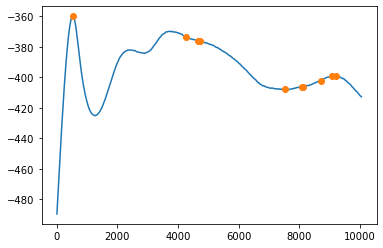

In [23]:
plt.plot(gdf.distan_cum,gdf.ice_base)
plt.plot(mins.distan_cum,mins.ice_base,'o')

In [24]:
gdf['ditdx'] = gdf.ice_thickn.diff()/gdf.dx

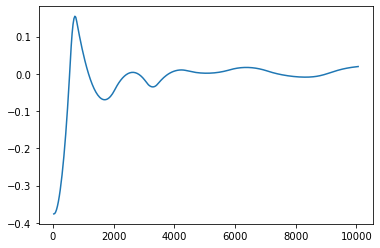

In [16]:
plt.plot(gdf.distan_cum,gdf.ditdx)

### Plot this against the REMA melt zone

In [28]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
    extent_diff= [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100

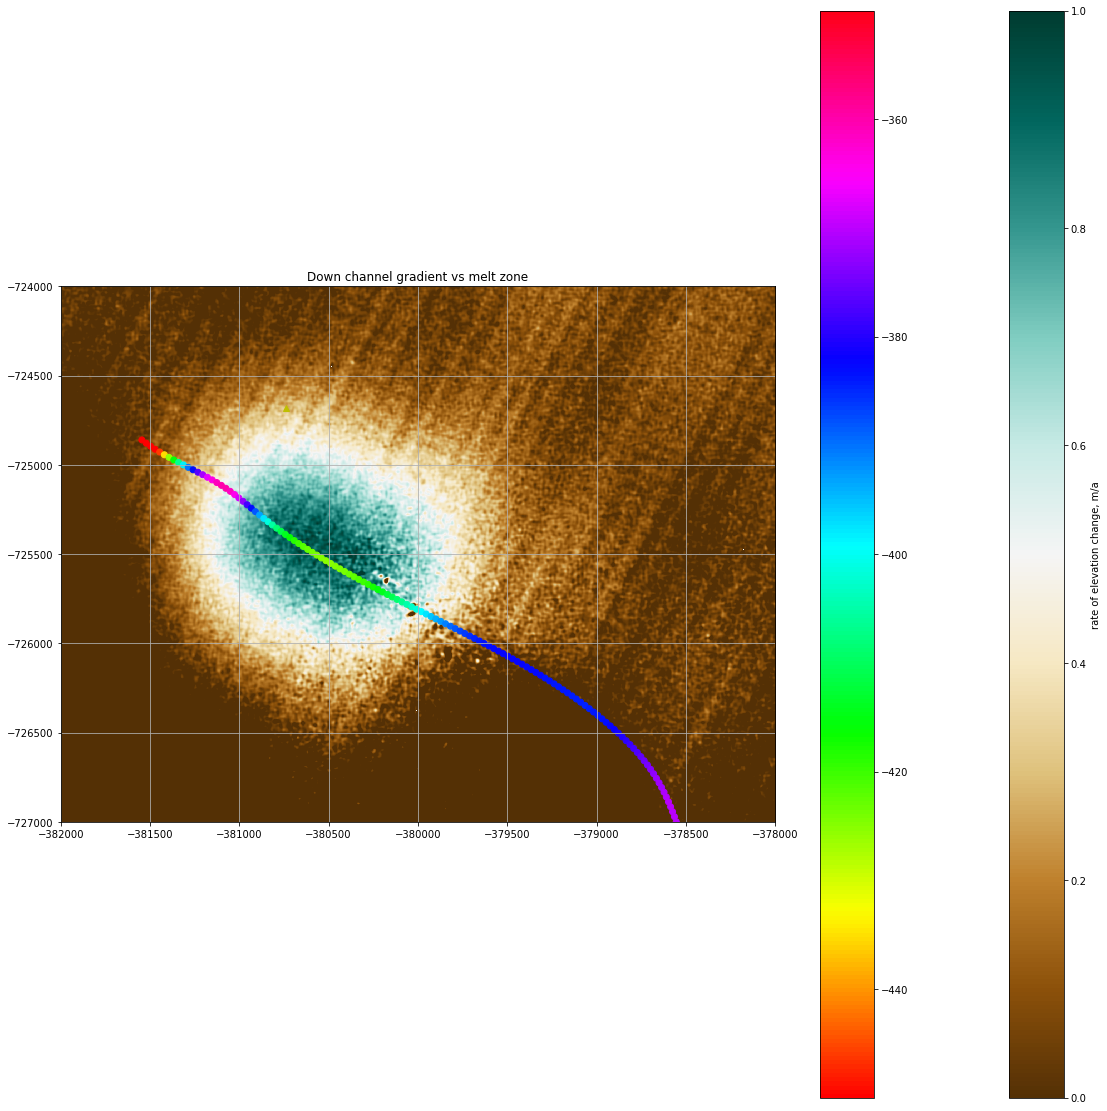

In [29]:
#rema
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]
plt.figure(figsize=(20,20))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_diff, vmin=v[0],vmax=v[1],cmap='BrBG')
cb = plt.colorbar()
plt.plot(kis2[0],kis2[1],'y^')
cb.set_label('rate of elevation change, m/a')

plt.scatter( gdf.x,gdf.y,c=gdf.ice_base,vmin=-450, vmax=-350,cmap='hsv')

plt.colorbar()
plt.title('Down channel gradient vs melt zone')
plt.xlim([-382000, -378000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

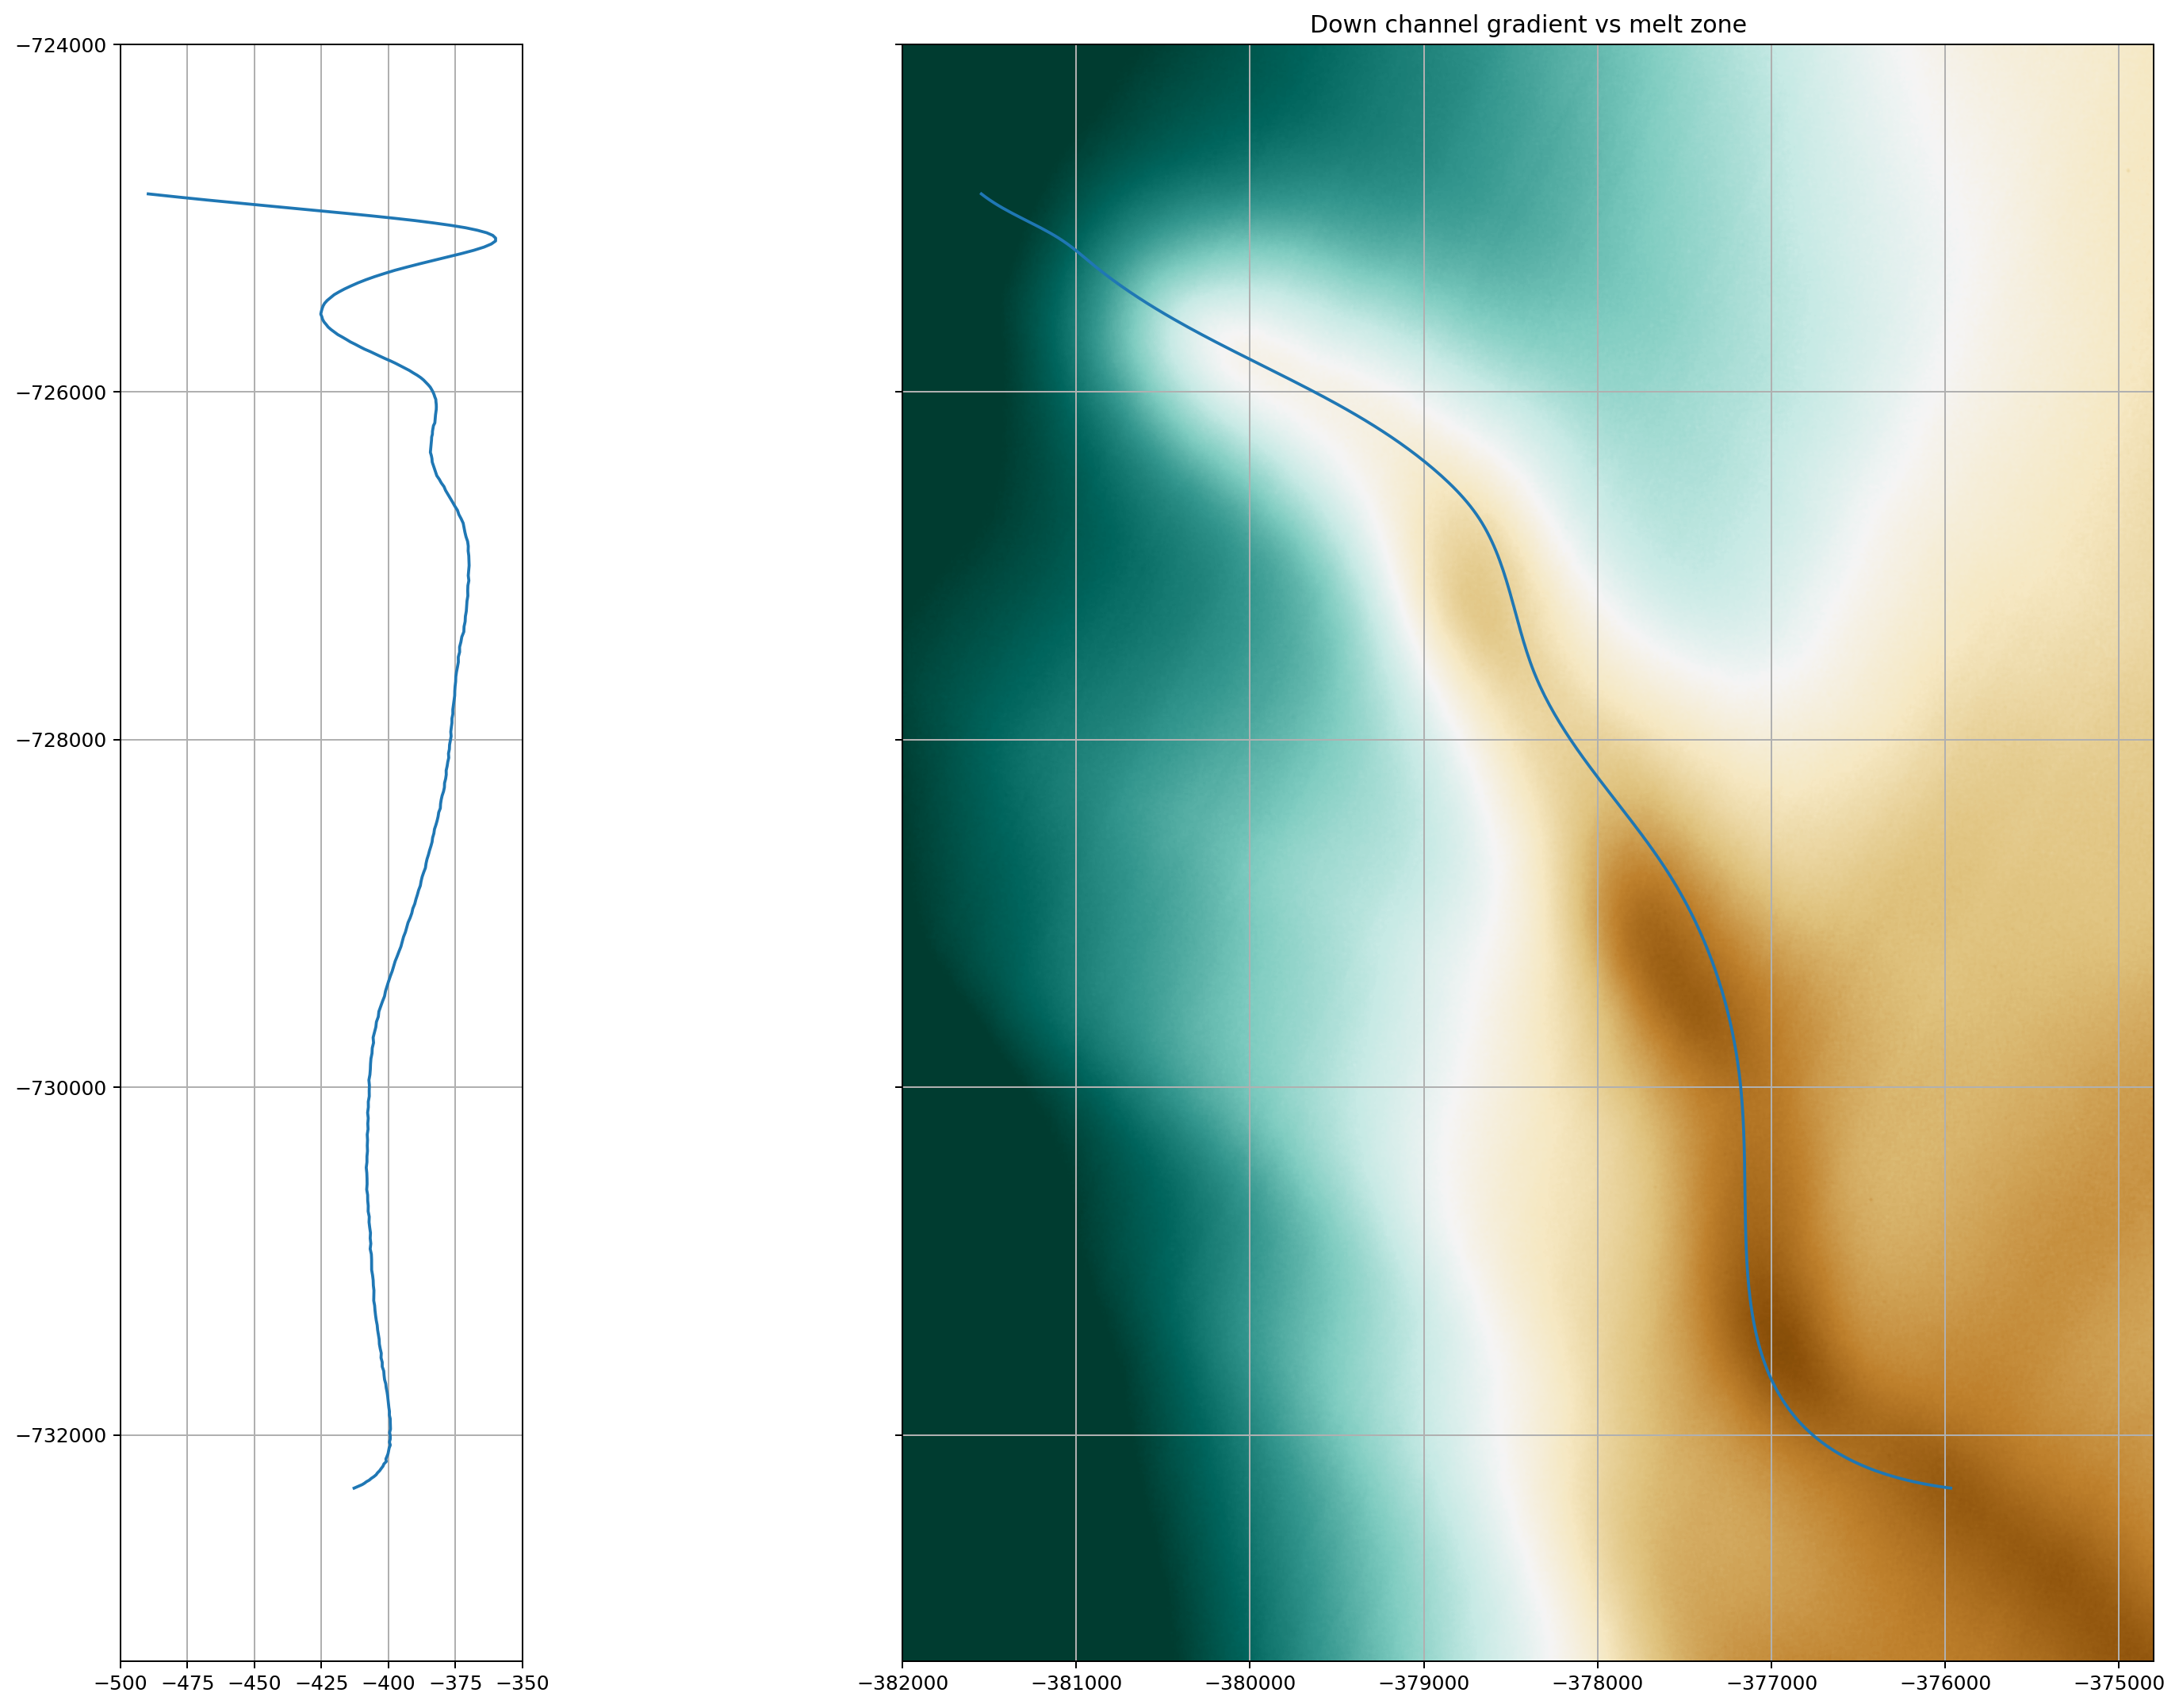

In [31]:

#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[1, 4],'height_ratios':[1]},
                               figsize=(20,15),dpi=180)#rema ,constrained_layout=True
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]

ax2.imshow(im_REMA,extent=extent_REMA,vmin=0.2,vmax=0.7, cmap='BrBG')
# cb = plt.colorbar()
# cb.set_label('surface elevation (?)')
# cb.set_label('rate of elevation change, m/a')
ax2.plot( gdf.x,gdf.y)
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.grid()

ax1.plot(gdf.ice_base,gdf.y)
ax1.set_xlim([-500, -350])
ax1.set_ylim([-733300,-724000])

ax2.set_title('Down channel gradient vs melt zone')

ax1.grid()
fig.show()

In [25]:
# %matplotlib qt


#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax2, ax1) = plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[4, 1],'height_ratios':[1]},
                               figsize=(6.5,15),dpi=180)#rema ,constrained_layout=True
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]

ax2.imshow(im_REMA,extent=extent_REMA,vmin=0.2,vmax=0.7, cmap='BrBG')
# cb = plt.colorbar()
# cb.set_label('surface elevation (?)')
# cb.set_label('rate of elevation change, m/a')
ax2.plot( gdf.x,gdf.y)
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.set_xlabel('UTM x, m')
ax2.set_ylabel('UTM y, m')
ax2.grid()

ax1.plot(gdf.ice_thickn,gdf.y)
# ax1.set_xlim([400, 480])
ax1.set_ylim([-733300,-724000])
ax1.set_xlabel('ice thickness, m')
# ax1.set_ylabel('UTM y, m')

# ax2.set_title('Down channel gradient vs melt zone')

ax1.grid()
fig.show()

In [23]:
#output shape file of middle of channel


gdf.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/SHARE_SHAPEFILES/interpolated_channel_mid.shp')